In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [26]:
import attr
import re
import numpy as np
import ujson

from collections import Counter, defaultdict
from itertools import islice
from boltons.iterutils import windowed
from tqdm import tqdm_notebook
from textblob import TextBlob
from glob import glob

from scipy.stats import spearmanr

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [41]:
class Corpus:
    
    def __init__(self, pattern, skim=None):
        self.pattern = pattern
        self.skim = skim
        
    def lines(self):
        for path in glob(self.pattern):
            with open(path) as fh:
                for line in fh:
                    yield line.strip()

    def abstracts(self):
        lines = self.lines()
        if self.skim:
            lines = islice(lines, self.skim)
        for line in tqdm_notebook(lines, total=self.skim):
            raw = ujson.loads(line)
            yield Abstract.from_raw(raw)
            
    def xy(self, vocab):
        for abstract in self.abstracts():
            yield from abstract.xy(vocab)
            
    def ngram_counts(self, n):
        counts = defaultdict(lambda: 0)
        for ab in self.abstracts():
            for sent in ab.sentences:
                for ngram in sent.ngrams(n):
                    counts[ngram] += 1
        return Counter(counts)
            
    def most_common_ngrams(self, n, depth):
        counts = self.ngram_counts(n)
        return set([k for k, _ in counts.most_common(depth)])

In [42]:
class Abstract:
    
    @classmethod
    def from_raw(cls, raw):
        return cls([Sentence(s['token']) for s in raw['sentences']])
    
    def __init__(self, sentences):
        self.sentences = sentences
    
    def sentence_tokens(self):
        for sent in self.sentences:
            yield re.findall('[a-z]+', sent.lower())
    
    def xy(self, vocab):
        for i, sent in enumerate(self.sentences):
            x = sent.features(vocab)
            y = i / (len(self.sentences)-1)
            yield x, y

In [43]:
class Sentence:
    
    def __init__(self, tokens):
        self.tokens = tokens
    
    def ngrams(self, n=1):
        for ng in windowed(self.tokens, n):
            yield '_'.join(ng)
            
    def ngram_counts(self, vocab, maxn=3):
        for n in range(1, maxn+1):
            counts = Counter(self.ngrams(n))
            for k, v in counts.items():
                if k in vocab:
                    yield f'_{k}', v
                    
    def word_count(self):
        return len(self.tokens)
                
    def _features(self, vocab):
        yield from self.ngram_counts(vocab)
        yield 'word_count', self.word_count()
        
    def features(self, vocab):
        return dict(self._features(vocab))

In [44]:
train = Corpus('/Users/dclure/Projects/sent-order/data/train.json/*.json', 100000)

In [45]:
vocab = (
    train.most_common_ngrams(1, 2000) |
    train.most_common_ngrams(2, 2000) |
    train.most_common_ngrams(3, 2000)
)

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

In [47]:
len(vocab)

6000

In [49]:
dv = DictVectorizer()

In [50]:
train_x, train_y = zip(*train.xy(vocab))

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

In [51]:
train_x = dv.fit_transform(train_x)

In [52]:
train_x

<537608x6001 sparse matrix of type '<class 'numpy.float64'>'
	with 16050889 stored elements in Compressed Sparse Row format>

In [53]:
model = LinearRegression()

In [54]:
fit = model.fit(train_x, train_y)

In [57]:
test = Corpus('/Users/dclure/Projects/sent-order/data/test.json/*.json', 50000)

In [58]:
test_x, test_y = zip(*test.xy(vocab))

HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

In [59]:
test_x = dv.transform(test_x)

In [60]:
r2_score(test_y, fit.predict(test_x))

0.3254300477730524

In [61]:
names = dv.get_feature_names()

In [62]:
bidx = fit.coef_.argsort()
eidx = np.flip(fit.coef_.argsort(), 0)

In [63]:
for i in bidx[:50]:
    print(fit.coef_[i], names[i])

-0.418988714658 _&_amp
-0.341001627436 _+_/-
-0.2467920484 _Let
-0.238633987139 _Recent
-0.236773751504 _-_called
-0.231661426509 _We_study
-0.231235221045 _in_terms_of
-0.22752523618 _-_Mills
-0.207089102537 _We_report
-0.193345548816 _We_investigate
-0.190474699881 _We_consider
-0.188660227185 _In_addition_to
-0.188357459228 _This_paper
-0.187142470885 _pre_-
-0.185877869338 _Recently
-0.182041399758 _is_proposed_.
-0.178950097369 _this_paper_.
-0.178414533743 _We_present
-0.169376411571 _known_that
-0.167614239751 _We_review
-0.161012763164 _of_-
-0.157887453144 _Our_results_show
-0.157630142138 _is_one_of
-0.153237327912 _Sloan_Digital_Sky
-0.152555593412 _We_introduce
-0.151974008675 _The_problem_of
-0.151707599191 _particular_,
-0.150220694078 _In_the_first
-0.148830024527 _other_hand
-0.147764548538 _the_context_of
-0.147751560838 _One_of_the
-0.145538575539 _co
-0.141078021732 _is_devoted_to
-0.139084304731 _is_considered
-0.137849054664 _with_respect_to
-0.137474310295 _often


In [64]:
for i in eidx[:50]:
    print(fit.coef_[i], names[i])

0.364640258335 _/-
0.360535009896 _Finally
0.280688116882 _&_lt
0.239524656482 _In_addition
0.228274420816 _Also
0.226334975917 _Furthermore
0.221275220608 _We_have_also
0.215103271894 _Moreover
0.210797450422 _comment_on_the
0.210539877842 _in_terms
0.210436302601 _pre
0.203561664844 _Further
0.202167764047 _conclude
0.199337982179 _Thus
0.181925145569 _the_other_hand
0.181228553421 _implications
0.177371852495 _In_this_way
0.176416234569 _&_amp_;
0.176416234569 _amp_;
0.173581688259 _We_conclude
0.169447190476 _findings
0.169323072549 _illustrate
0.166881871674 _can_be_understood
0.164153402719 _light_on_the
0.160060445613 _co_-
0.156104712348 _in_particular_,
0.155602048784 _In_particular
0.154423457125 _Yang_-_Mills
0.154149061443 _In_this_case
0.153372049909 _We_also
0.152233455668 _with_respect
0.151775822284 _(_iii_)
0.149606037071 _Therefore
0.149481015365 _so_-
0.147854620366 _The_proposed
0.147810258243 _Phys_._Rev
0.147091665713 _suggests
0.146206251154 _Our
0.146168435582 _

In [65]:
correct = Counter()
total = Counter()

for ab in test.abstracts():
    
    x, _ = zip(*ab.xy(vocab))
    x = dv.transform(x)
    
    order = list(fit.predict(x).argsort().argsort())
    
    if sorted(order) == order:
        correct[len(order)] += 1
        
    total[len(order)] += 1

HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

In [66]:
for slen in sorted(correct.keys()):
    print(slen, correct[slen] / total[slen])

2 0.8846823324630113
3 0.5455125750031916
4 0.2558089033659066
5 0.08975791433891993
6 0.02608832311802609
7 0.006464124111182934
8 0.00030039050765995795
9 0.0004361098996947231


In [67]:
sum(correct.values()) / sum(total.values())

0.23232

# Sentence length vs. percentage correct

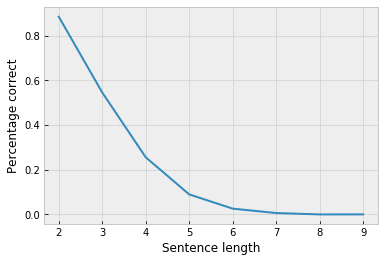

In [68]:
x = sorted(correct.keys())
y = [correct[slen] / total[slen] for slen in x]

plt.xlabel('Sentence length')
plt.ylabel('Percentage correct')
plt.plot(x, y)